# AnoGAN

In [1]:
from model.dcgan import DCGAN
from model.anogan import AnoGAN

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, Input, MaxPool2D, UpSampling2D, BatchNormalization, Activation, Dropout, ZeroPadding2D
%matplotlib inline

In [2]:
EPOCHS = 50
NOISE_DIM = 100

IMAGE_SIZE = (64, 64)
CHANNELS = 1
IMAGE_SHAPE = IMAGE_SIZE + tuple([CHANNELS])

## Dataset

In [3]:
TRAIN_PATH = r"C:\Users\filip\Desktop\Universita\Laboratorio di Intelligenza Artificiale\hazelnut\train"
TEST_PATH = r"C:\Users\filip\Desktop\Universita\Laboratorio di Intelligenza Artificiale\hazelnut\test"

training_set = tf.keras.utils.image_dataset_from_directory(TRAIN_PATH, 
                                                           image_size = IMAGE_SIZE, 
                                                           color_mode = "grayscale",
                                                           batch_size = None, 
                                                           shuffle = False)
test_set = tf.keras.utils.image_dataset_from_directory(TEST_PATH, 
                                                       image_size = IMAGE_SIZE, 
                                                       color_mode = "grayscale",
                                                       batch_size = None,
                                                       shuffle = False)

Found 391 files belonging to 1 classes.
Found 110 files belonging to 5 classes.


### Normalizzazione

In [4]:
normalization_layer = tf.keras.layers.Rescaling(scale = (1./127.5), offset = -1)

normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
normalized_test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

In [5]:
BUFFER_SIZE = 391
BATCH_SIZE = 17
normalized_training_set = normalized_training_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
len(normalized_training_set)

23

## GAN

In [7]:
gan = DCGAN(IMAGE_SHAPE, NOISE_DIM)

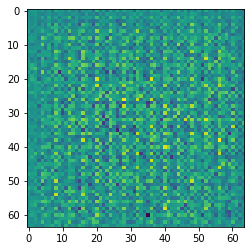

In [8]:
img = gan.generator(tf.random.normal([1,100]))

plt.imshow(img[0, :, :, 0])
plt.show()

In [9]:
print(gan.discriminator(img))

tf.Tensor([[0.00017599]], shape=(1, 1), dtype=float32)


## Training

In [ ]:
gan.restore()
disc_loss, gen_loss = gan.train(normalized_training_set, EPOCHS*5)

In [10]:
gan.restore()

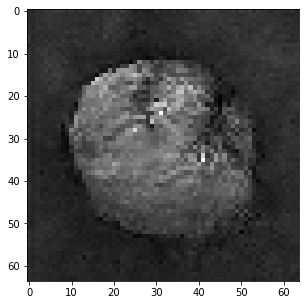

In [12]:
plt.figure(figsize = (5, 5))

generated_image = gan.generator(tf.random.normal([1, NOISE_DIM]))
generated_image = np.array(generated_image[0] * 127.5 + 127.5, np.int32)
plt.imshow(generated_image, cmap="gray")
plt.show()

In [ ]:
plt.plot(disc_loss)
plt.plot(gen_loss)
plt.show()

## Anomaly Detection

In [13]:
anogan = AnoGAN(gan)

In [20]:
test_image = []
for image, label in normalized_test_set:
    test_image = image.numpy()
    break
test_image = np.array([test_image])
anomaly_score, similar_img = anogan.anomaly_detection(test_image)

1/1 [==============================] - 0s 17ms/step


In [21]:
print(anomaly_score)

1172.102294921875


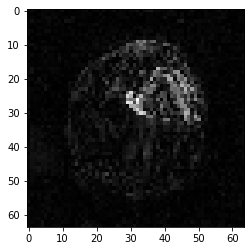

In [29]:
t = np.array((test_image[0] * 127.5) + 127.5, np.int32)
s = np.array((similar_img[0] * 127.5) + 127.5, np.int32)
plt.imshow(abs(t-s), cmap = "gray")
plt.show()

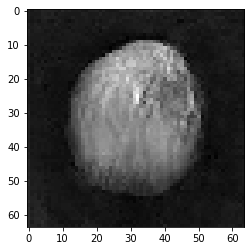

In [26]:
plt.imshow(s, cmap = "gray")

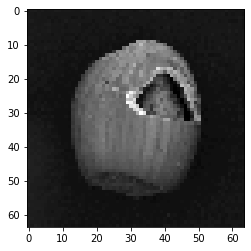

In [27]:
plt.imshow(t, cmap="gray")

In [30]:
gan.generator.save_weights(r"weights\generator.h5", save_format="h5")